In [1]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import numpy as np
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.set_random_seed(seed)


# 데이터 읽어 들이기--- (※1)
#ci_year	ci_term	si_grad	si_ent_gubun	agescale	si_sex	si_last_hak	schoarYn	
#accept_point	avg_logincnt	avg_att_time	avg_att_rate	avg_bbscnt	avg_startlogin	entYn	classcnt	
#avg_te_avg	avg_te_passrate	gradcnt	counsel	stdResult
features =14
#features =13
#filename="./dataset/20200612_2018_2019.csv"
#filename="./dataset/20200614_v1.csv"
filename="./dataset/20200717_v1.csv"

df_pre=pd.read_csv(filename,encoding="cp949", header=0) # CSV파일을 불러오는 함수를 이용
#df_pre=pd.read_csv('./dataset/20200612_app_point.csv',encoding="cp949", header=0) # CSV파일을 불러오는 함수를 이용





Using TensorFlow backend.
C:\Users\hiranMain\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hiranMain\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hiranMain\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hiranMain\anaconda3\lib\site-packages\tensorflow\python\fra

In [2]:
print("데이터의 총 수", len(df_pre))



데이터의 총 수 92849


In [3]:
df_pre.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92849 entries, 0 to 92848
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   entYn           92849 non-null  int64  
 1   si_grad         92849 non-null  int64  
 2   si_ent_gubun    92849 non-null  int64  
 3   agescale        92849 non-null  int64  
 4   si_sex          92849 non-null  int64  
 5   si_last_hak     92849 non-null  int64  
 6   schoarYn        92849 non-null  int64  
 7   avg_logincnt    92849 non-null  int64  
 8   avg_att_time    92849 non-null  int64  
 9   avg_att_rate    92849 non-null  float64
 10  avg_startlogin  92849 non-null  int64  
 11  parti           92849 non-null  int64  
 12  pre_avg_te_avg  92849 non-null  float64
 13  pre_gradcnt     92849 non-null  int64  
 14  stdResult       92849 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 10.6 MB


In [4]:

df_pre.tail()

,entYn,si_grad,si_ent_gubun,agescale,si_sex,si_last_hak,schoarYn,avg_logincnt,avg_att_time,avg_att_rate,avg_startlogin,parti,pre_avg_te_avg,pre_gradcnt,stdResult
92844,0,4,2,20,2,3,1,81,338,100.0,34,70,4.00,3,0
92845,0,4,2,20,1,3,1,49,297,100.0,21,87,3.00,3,0
92846,0,4,2,20,2,2,1,45,405,100.0,19,100,4.19,3,0
92847,0,4,2,30,2,2,1,33,174,97.5,16,100,3.08,3,0
92848,0,4,2,20,2,3,1,80,330,100.0,40,100,4.19,3,0


In [5]:
# 데이터 내부의 기호를 숫자로 변환하기--- (※2)
df = df_pre.sample(frac=1)


dataset = df.values
X = dataset[:,0:features]
Y = dataset[:,features]

# 학습 전용과 테스트 전용 데이터로 나누기 --- (※3)
#테스트, 검증데이터 분할 7:3 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

#데이터 정규화
X_train, X_test = X_train / 255, X_test / 255

from keras.layers import Dense, Dropout, Activation
# 모델 설정
model = Sequential()
model.add(Dense(28,  input_dim=features, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(8, activation='relu'))
#model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#모델 컴파일
model.compile(loss='binary_crossentropy',
#model.compile(loss='mean_squared_error',
           optimizer='adam',
           # metrics=['accuracy'])
           metrics=['accuracy',recall_m,precision_m,f1_m])

# 학습 자동 중단 설정 성능이 개선되지 않는 epch 100번까지 수용
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)



# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
   os.mkdir(MODEL_DIR)

# 모델 저장 조건 설정
modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)


# 모델 실행 및 저장
history = model.fit(X_train, Y_train, validation_split=0.20, epochs=500, batch_size=100, 
                    callbacks=[early_stopping_callback, checkpointer])

# 결과 출력
print("\n epoches-500, bat_size=10")
print("\n 학습중단 + 모델 성능개선 : early_stopping_callback:")
print("\n 예측정확도: %.4f" % (model.evaluate(X_test, Y_test)[1]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 51995 samples, validate on 12999 samples
Epoch 1/500
51995/51995 [==============================] - 1s 13us/step - loss: 0.6502 - accuracy: 0.6103 - recall_m: 0.6962 - precision_m: 0.5813 - f1_m: 0.6250 - val_loss: 0.5924 - val_accuracy: 0.7040 - val_recall_m: 0.8378 - val_precision_m: 0.6581 - val_f1_m: 0.7357

Epoch 00001: val_loss improved from inf to 0.59236, saving model to ./model/01-0.5924.hdf5
Epoch 2/500
51995/51995 [==============================] - 0s 9us/step - loss: 0.4910 - accuracy: 0.7786 - recall_m: 0.7614 - precision_m: 0.8030 - f1_m: 0.7741 - val_loss: 0.4257 - val_accuracy: 0.8095 - val_recall_m: 0.7806 - val_precision_m: 0.8250 - val_f1_m: 0.8008

Epoch 00002: val_loss improved from 0.59236 to 0.42574, saving model to ./model/02-0.4257.hdf5
Epoch 3/500
51995/51995 [==============================] - 0s 9us/step - loss: 0.3783 - accuracy: 0.8345 - recall_m: 0.7567 

51995/51995 [==============================] - 0s 8us/step - loss: 0.3220 - accuracy: 0.8527 - recall_m: 0.7480 - precision_m: 0.9483 - f1_m: 0.8341 - val_loss: 0.3321 - val_accuracy: 0.8492 - val_recall_m: 0.7295 - val_precision_m: 0.9557 - val_f1_m: 0.8259

Epoch 00023: val_loss improved from 0.33222 to 0.33210, saving model to ./model/23-0.3321.hdf5
Epoch 24/500
51995/51995 [==============================] - 0s 8us/step - loss: 0.3216 - accuracy: 0.8519 - recall_m: 0.7473 - precision_m: 0.9476 - f1_m: 0.8334 - val_loss: 0.3336 - val_accuracy: 0.8461 - val_recall_m: 0.7548 - val_precision_m: 0.9204 - val_f1_m: 0.8279

Epoch 00024: val_loss did not improve from 0.33210
Epoch 25/500
51995/51995 [==============================] - 0s 9us/step - loss: 0.3214 - accuracy: 0.8528 - recall_m: 0.7489 - precision_m: 0.9477 - f1_m: 0.8344 - val_loss: 0.3366 - val_accuracy: 0.8438 - val_recall_m: 0.7665 - val_precision_m: 0.9041 - val_f1_m: 0.8282

Epoch 00025: val_loss did not improve from 0.332

51995/51995 [==============================] - 0s 8us/step - loss: 0.3145 - accuracy: 0.8557 - recall_m: 0.7546 - precision_m: 0.9479 - f1_m: 0.8383 - val_loss: 0.3258 - val_accuracy: 0.8498 - val_recall_m: 0.7272 - val_precision_m: 0.9594 - val_f1_m: 0.8257

Epoch 00047: val_loss did not improve from 0.32554
Epoch 48/500
51995/51995 [==============================] - 0s 8us/step - loss: 0.3132 - accuracy: 0.8557 - recall_m: 0.7545 - precision_m: 0.9476 - f1_m: 0.8379 - val_loss: 0.3295 - val_accuracy: 0.8468 - val_recall_m: 0.7090 - val_precision_m: 0.9745 - val_f1_m: 0.8190

Epoch 00048: val_loss did not improve from 0.32554
Epoch 49/500
51995/51995 [==============================] - 0s 8us/step - loss: 0.3127 - accuracy: 0.8565 - recall_m: 0.7559 - precision_m: 0.9492 - f1_m: 0.8394 - val_loss: 0.3251 - val_accuracy: 0.8513 - val_recall_m: 0.7472 - val_precision_m: 0.9404 - val_f1_m: 0.8312

Epoch 00049: val_loss improved from 0.32554 to 0.32512, saving model to ./model/49-0.3251.hd

51995/51995 [==============================] - 0s 8us/step - loss: 0.3054 - accuracy: 0.8578 - recall_m: 0.7652 - precision_m: 0.9413 - f1_m: 0.8421 - val_loss: 0.3178 - val_accuracy: 0.8533 - val_recall_m: 0.7481 - val_precision_m: 0.9445 - val_f1_m: 0.8334

Epoch 00071: val_loss did not improve from 0.31711
Epoch 72/500
51995/51995 [==============================] - 0s 8us/step - loss: 0.3044 - accuracy: 0.8588 - recall_m: 0.7672 - precision_m: 0.9410 - f1_m: 0.8433 - val_loss: 0.3195 - val_accuracy: 0.8538 - val_recall_m: 0.7725 - val_precision_m: 0.9196 - val_f1_m: 0.8382

Epoch 00072: val_loss did not improve from 0.31711
Epoch 73/500
51995/51995 [==============================] - 0s 8us/step - loss: 0.3042 - accuracy: 0.8593 - recall_m: 0.7673 - precision_m: 0.9425 - f1_m: 0.8437 - val_loss: 0.3153 - val_accuracy: 0.8544 - val_recall_m: 0.7537 - val_precision_m: 0.9407 - val_f1_m: 0.8353

Epoch 00073: val_loss improved from 0.31711 to 0.31526, saving model to ./model/73-0.3153.hd

51995/51995 [==============================] - 0s 8us/step - loss: 0.3010 - accuracy: 0.8599 - recall_m: 0.7710 - precision_m: 0.9402 - f1_m: 0.8452 - val_loss: 0.3143 - val_accuracy: 0.8528 - val_recall_m: 0.7797 - val_precision_m: 0.9102 - val_f1_m: 0.8385

Epoch 00095: val_loss did not improve from 0.31298
Epoch 96/500
51995/51995 [==============================] - 0s 9us/step - loss: 0.3010 - accuracy: 0.8598 - recall_m: 0.7724 - precision_m: 0.9376 - f1_m: 0.8449 - val_loss: 0.3135 - val_accuracy: 0.8548 - val_recall_m: 0.7392 - val_precision_m: 0.9581 - val_f1_m: 0.8328

Epoch 00096: val_loss did not improve from 0.31298
Epoch 97/500
51995/51995 [==============================] - 0s 8us/step - loss: 0.3018 - accuracy: 0.8606 - recall_m: 0.7715 - precision_m: 0.9410 - f1_m: 0.8458 - val_loss: 0.3219 - val_accuracy: 0.8502 - val_recall_m: 0.7882 - val_precision_m: 0.8969 - val_f1_m: 0.8377

Epoch 00097: val_loss did not improve from 0.31298
Epoch 98/500
51995/51995 [===============


Epoch 00119: val_loss did not improve from 0.31097
Epoch 120/500
51995/51995 [==============================] - 0s 8us/step - loss: 0.2998 - accuracy: 0.8596 - recall_m: 0.7731 - precision_m: 0.9369 - f1_m: 0.8451 - val_loss: 0.3115 - val_accuracy: 0.8551 - val_recall_m: 0.7514 - val_precision_m: 0.9455 - val_f1_m: 0.8356

Epoch 00120: val_loss did not improve from 0.31097
Epoch 121/500
51995/51995 [==============================] - 0s 8us/step - loss: 0.2997 - accuracy: 0.8599 - recall_m: 0.7731 - precision_m: 0.9371 - f1_m: 0.8453 - val_loss: 0.3184 - val_accuracy: 0.8511 - val_recall_m: 0.7979 - val_precision_m: 0.8907 - val_f1_m: 0.8404

Epoch 00121: val_loss did not improve from 0.31097

 epoches-500, bat_size=10

 학습중단 + 모델 성능개선 : early_stopping_callback:
27855/27855 [==============================] - 0s 9us/step

 예측정확도: 0.8583


In [9]:
evaluateResult= model.evaluate(X_test, Y_test)   #X_test 으로 검증

loss = evaluateResult[0]
accuracy = evaluateResult[1]
recall  = evaluateResult[2]
precision  = evaluateResult[3]
f1_socre  = evaluateResult[4]

# 결과 출력\
print('Accuracy of DNN-4 Model: %.2f' % accuracy)
print("\n precision, recall, f1_score")
print("\n  %.4f, %4f, %.4f" % (precision ,recall, f1_socre))

27855/27855 [==============================] - 0s 10us/step
Accuracy of DNN-4 Model: 0.86

 precision, recall, f1_score

  0.9014, 0.805894, 0.8467


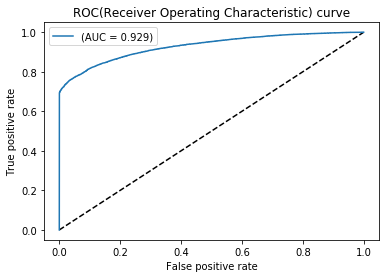

In [8]:
from sklearn.metrics import roc_curve

probs = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, probs)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC(Receiver Operating Characteristic) curve')
plt.legend(loc='best')
plt.show()